# Metric Percentiles

<a href="https://colab.research.google.com/github/netdata/netdata-community/blob/main/netdata-agent-api/netdata-pandas/metric_percentiles.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will pull some data for a subset of charts for some recent data and then overlay various percentiles for each metric. Finally we will sort all our metrics by those that have the highest "crossover rate" i.e. percent of visible observations that cross either the 95th or 5th percentile.

In [1]:
# if you need to, uncomment below to install netdata-pandas and seaborn packages
#!pip install plotly==4.14.1 netdata-pandas==0.0.33

In [2]:
import numpy as np
import pandas as pd
from datetime import timedelta
from netdata_pandas.data import get_data
import plotly.express as px
import plotly.graph_objects as go

Lets pull some data.

In [3]:
# inputs
hosts = ['london.my-netdata.io']
charts_regex = 'system.*'
before = 0
after = -60*15
ref_timedelta = timedelta(hours=24)

In [4]:
# get the data
df = get_data(hosts=hosts, charts_regex=charts_regex, after=after, before=before, index_as_datetime=True)
print(df.shape)
df.head()

(902, 72)


,system.active_processes|active,system.cpu|guest,system.cpu|guest_nice,system.cpu|iowait,system.cpu|irq,system.cpu|nice,system.cpu|softirq,system.cpu|steal,system.cpu|system,system.cpu|user,...,system.softirqs|RCU,system.softirqs|SCHED,system.softirqs|TASKLET,system.softirqs|TIMER,system.softnet_stat|dropped,system.softnet_stat|flow_limit_count,system.softnet_stat|processed,system.softnet_stat|received_rps,system.softnet_stat|squeezed,system.uptime|uptime
time_idx,,,,,,,,,,,,,,,,,,,,,
2020-12-18 17:36:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-18 17:36:01,210.0,0.0,0.0,0.0,0.0,0.0,0.249377,0.498753,0.997506,1.496259,...,123.09368,128.89643,52.90551,172.4687,0.0,0.0,167.18047,0.0,0.0,67448970.0
2020-12-18 17:36:02,210.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.252525,0.505050,1.767677,...,145.01458,136.48479,60.79770,182.5614,0.0,0.0,182.23810,0.0,0.0,67448970.0
2020-12-18 17:36:03,210.0,0.0,0.0,0.0,0.0,0.0,0.250627,0.751880,1.002506,1.002506,...,160.45371,136.05371,65.70897,194.8591,0.0,0.0,193.81780,0.0,0.0,67448970.0
2020-12-18 17:36:04,210.0,0.0,0.0,0.0,0.0,0.0,0.240385,6.490385,1.201923,1.442308,...,177.36200,158.45735,80.75822,230.4871,0.0,0.0,253.99700,0.0,0.0,67448970.0


In [5]:
# work out reference window
ref_before = int(df.index.min().timestamp())
ref_after = int((df.index.min() - ref_timedelta).timestamp())

# get the reference data
df_ref = get_data(hosts=hosts, charts_regex=charts_regex, after=ref_after, before=ref_before, index_as_datetime=True)
print(df_ref.shape)
df_ref.head()

(86400, 72)


,system.active_processes|active,system.cpu|guest,system.cpu|guest_nice,system.cpu|iowait,system.cpu|irq,system.cpu|nice,system.cpu|softirq,system.cpu|steal,system.cpu|system,system.cpu|user,...,system.softirqs|RCU,system.softirqs|SCHED,system.softirqs|TASKLET,system.softirqs|TIMER,system.softnet_stat|dropped,system.softnet_stat|flow_limit_count,system.softnet_stat|processed,system.softnet_stat|received_rps,system.softnet_stat|squeezed,system.uptime|uptime
time_idx,,,,,,,,,,,,,,,,,,,,,
2020-12-17 17:36:01,210.0,0.0,0.0,0.0,0.0,0.0,0.000000,2.977667,1.240695,0.744417,...,119.84388,102.77395,21.11661,150.54450,0.0,0.0,59.25083,0.0,0.0,67362570.0
2020-12-17 17:36:02,210.0,0.0,0.0,0.0,0.0,0.0,0.000000,3.649635,2.433090,0.973236,...,125.85624,113.14033,41.84823,172.72800,0.0,0.0,115.80647,0.0,0.0,67362570.0
2020-12-17 17:36:03,210.0,0.0,0.0,0.0,0.0,0.0,0.248139,2.481390,0.992556,0.992556,...,175.20720,137.32296,71.22533,201.40640,0.0,0.0,217.75950,0.0,0.0,67362570.0
2020-12-17 17:36:04,210.0,0.0,0.0,0.0,0.0,0.0,0.247525,2.475248,0.742574,0.742574,...,160.75384,126.14549,42.79052,176.84330,0.0,0.0,130.46574,0.0,0.0,67362570.0
2020-12-17 17:36:05,210.0,0.0,0.0,0.0,0.0,0.0,0.000000,3.178484,1.466993,1.222494,...,146.72806,107.24749,35.45862,162.35981,0.0,0.0,108.04238,0.0,0.0,67362570.0


In [6]:
# work out percentiles
df_ref_mean = df_ref.mean()
df_ref_median = df_ref.median()
df_ref_p1 = df_ref.quantile(0.01)
df_ref_p5 = df_ref.quantile(0.05)
df_ref_p95 = df_ref.quantile(0.95)
df_ref_p99 = df_ref.quantile(0.99)

In [7]:
# rank metrics as most interesting based on number of percentile crossovers
percentile_crossovers = []
for col in df.columns:
    if col in df_ref.columns:
        p99_crossovers = np.where(df[col] > df_ref_p99.loc[col], 1, 0).sum()
        p95_crossovers = np.where(df[col] > df_ref_p95.loc[col], 1, 0).sum()
        p5_crossovers = np.where(df[col] < df_ref_p5.loc[col], 1, 0).sum()
        p1_crossovers = np.where(df[col] < df_ref_p1.loc[col], 1, 0).sum()
        percentile_crossovers.append([col, p99_crossovers, p95_crossovers, p5_crossovers, p1_crossovers])

df_percentile_crossovers = pd.DataFrame(
    percentile_crossovers, 
    columns=['metric', 'p99_crossovers', 'p95_crossovers', 'p5_crossovers', 'p1_crossovers']
)
df_percentile_crossovers['total_crossovers'] = df_percentile_crossovers['p95_crossovers'] + df_percentile_crossovers['p5_crossovers']
df_percentile_crossovers['crossover_rate'] = round(df_percentile_crossovers['total_crossovers'] / len(df[col]),2)
df_percentile_crossovers['metric_rank'] = df_percentile_crossovers['crossover_rate'].rank(ascending=False)
df_percentile_crossovers = df_percentile_crossovers.set_index('metric')
df_percentile_crossovers = df_percentile_crossovers.sort_values('metric_rank')
df_percentile_crossovers

,p99_crossovers,p95_crossovers,p5_crossovers,p1_crossovers,total_crossovers,crossover_rate,metric_rank
metric,,,,,,,
system.uptime|uptime,901,901,0,0,901,1.00,1.0
system.softirqs|NET_TX,42,448,0,0,448,0.50,2.0
system.net|sent,0,0,315,58,315,0.35,3.5
system.ip|sent,0,0,317,55,317,0.35,3.5
system.ip|received,43,253,0,0,253,0.28,5.0
...,...,...,...,...,...,...,...
system.processes|blocked,0,0,4,4,4,0.00,56.0
system.interrupts|rtc0_8,0,0,0,0,0,0.00,56.0
system.ram|buffers,0,0,0,0,0,0.00,56.0


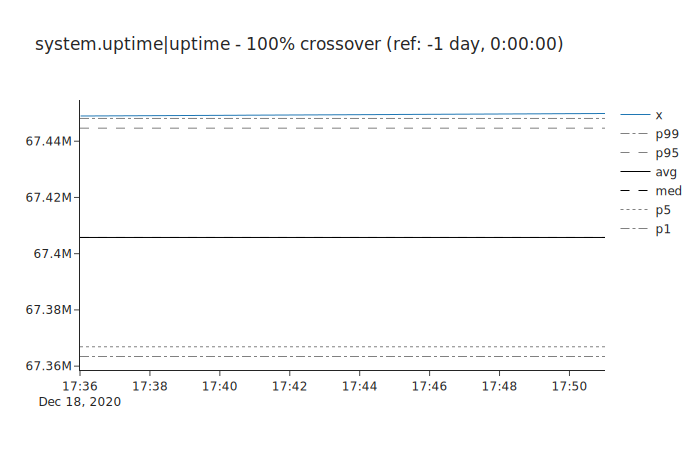

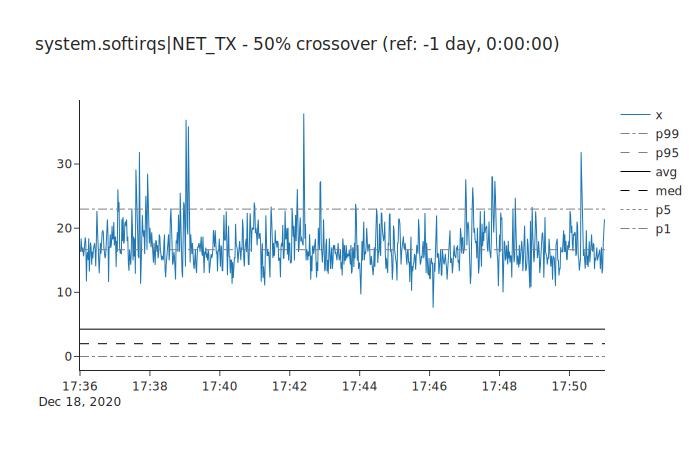

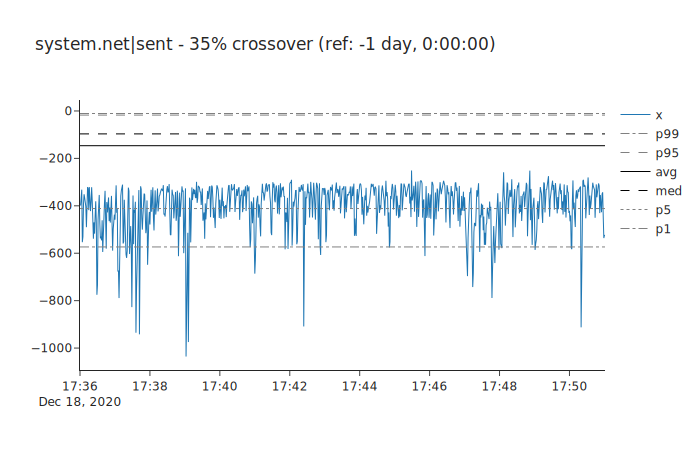

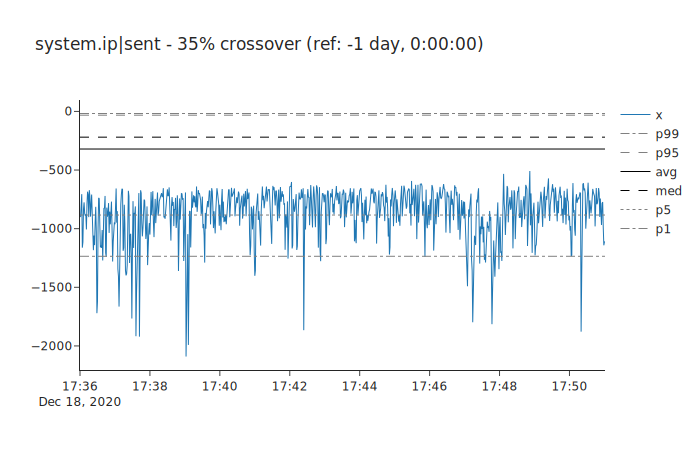

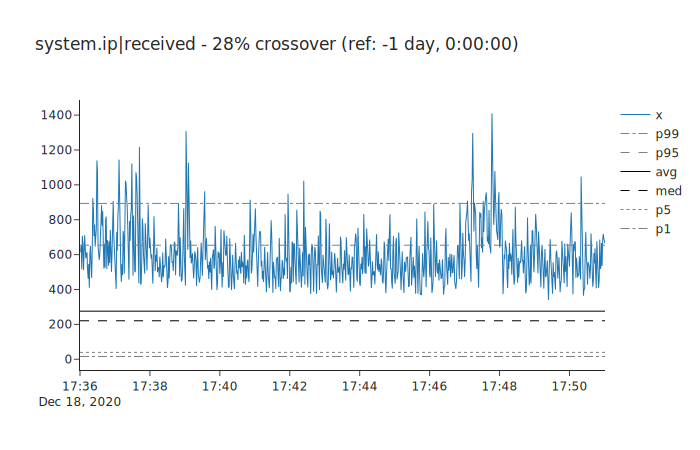

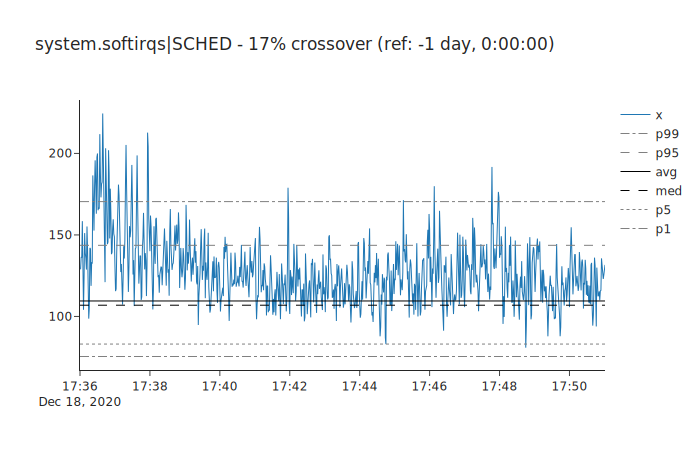

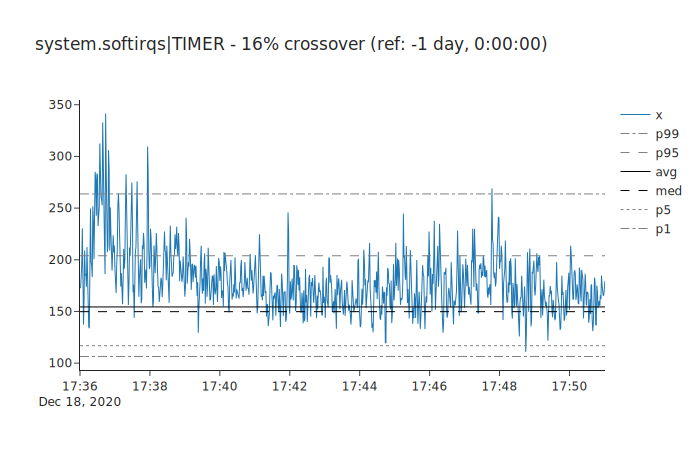

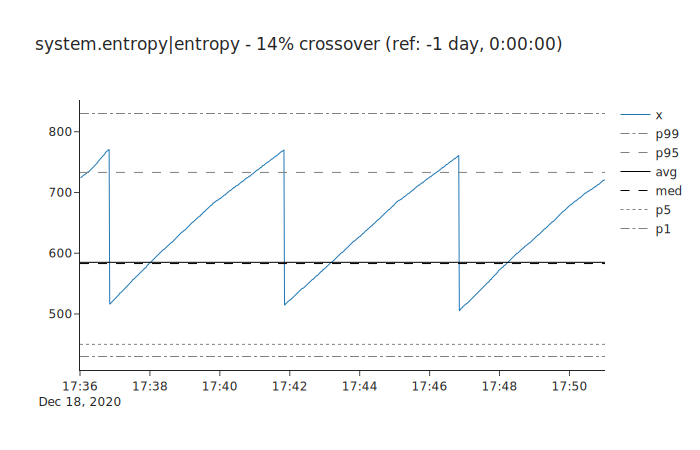

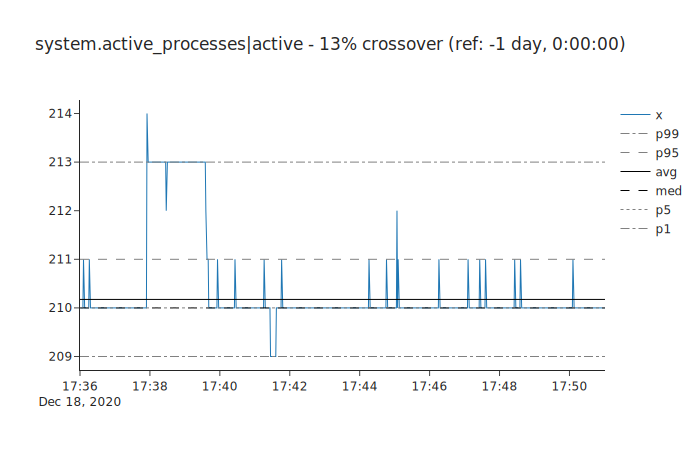

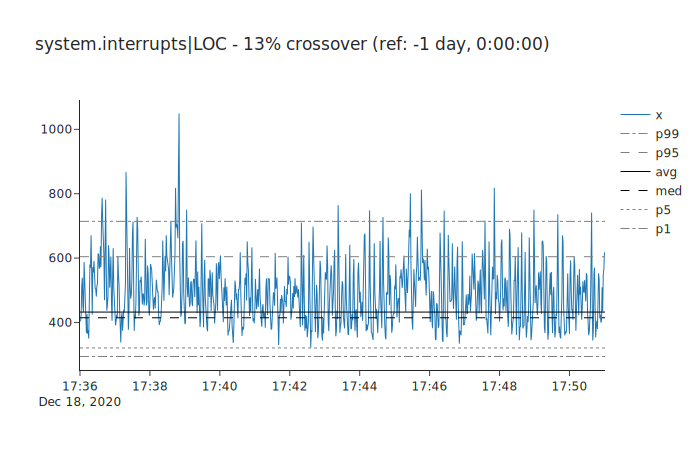

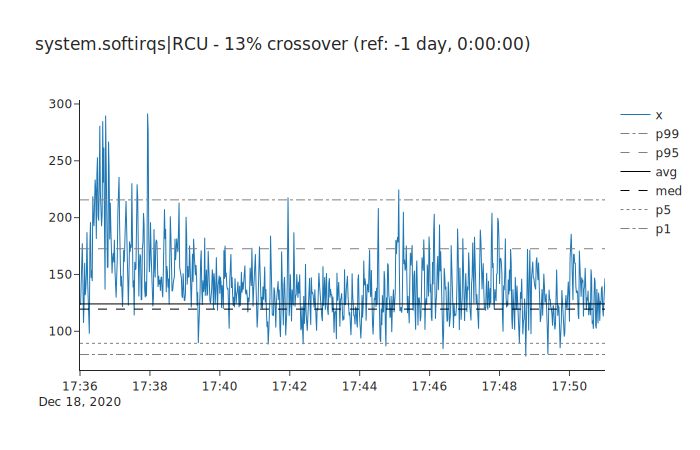

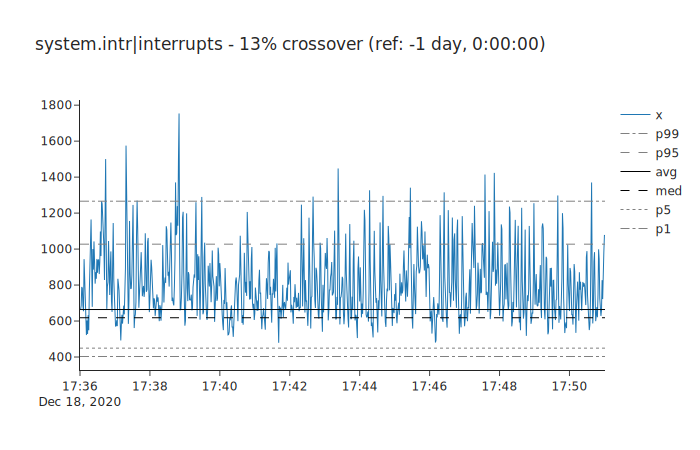

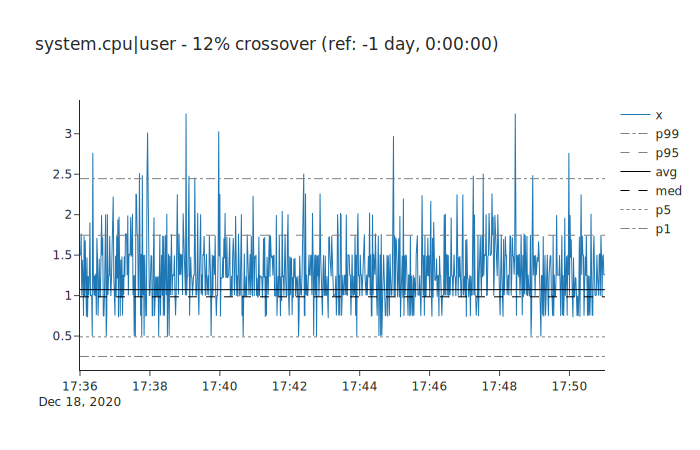

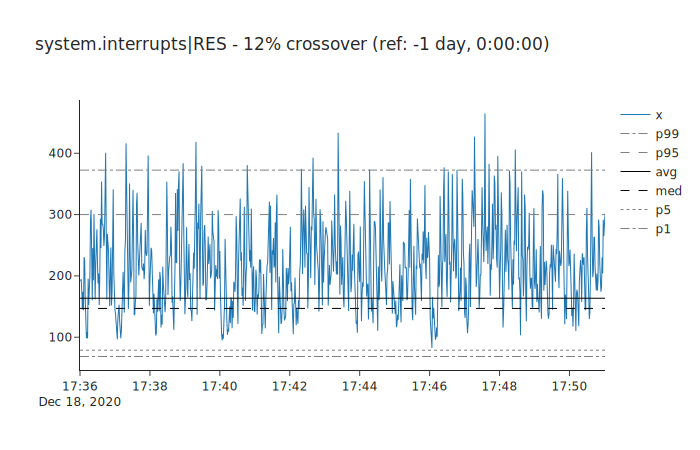

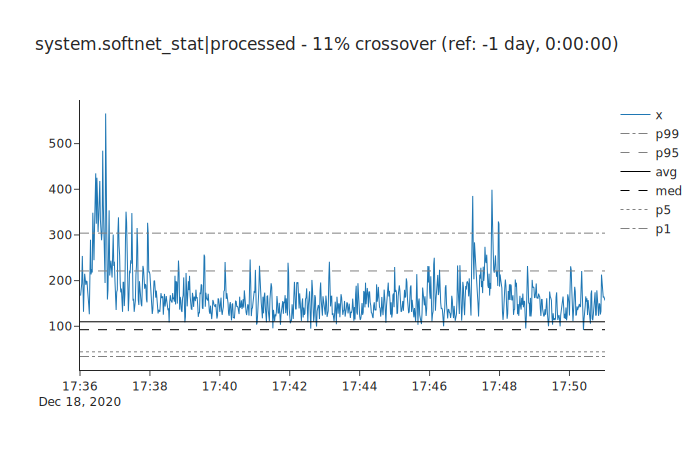

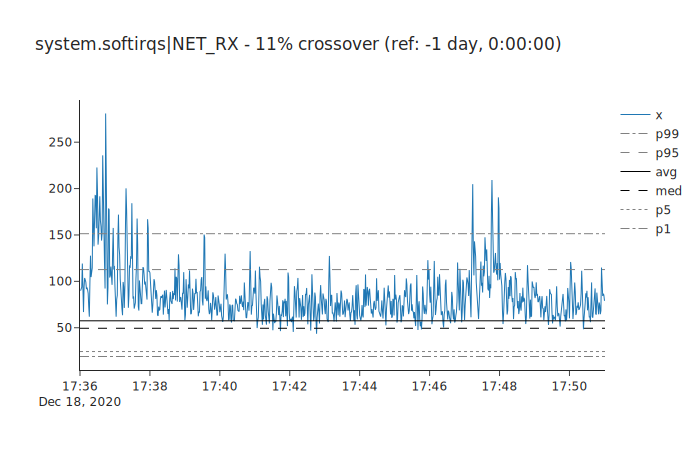

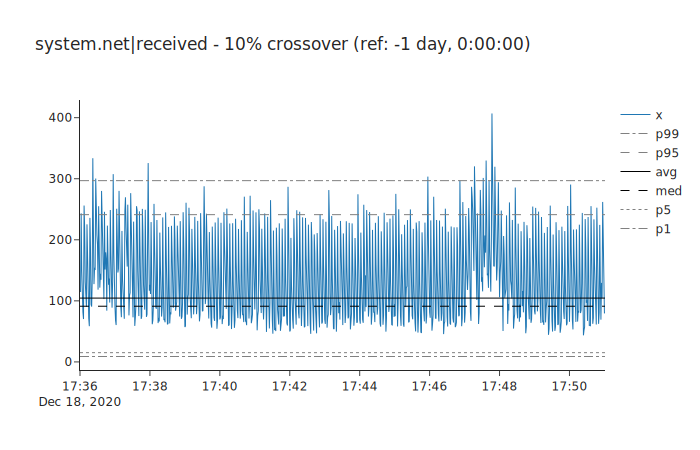

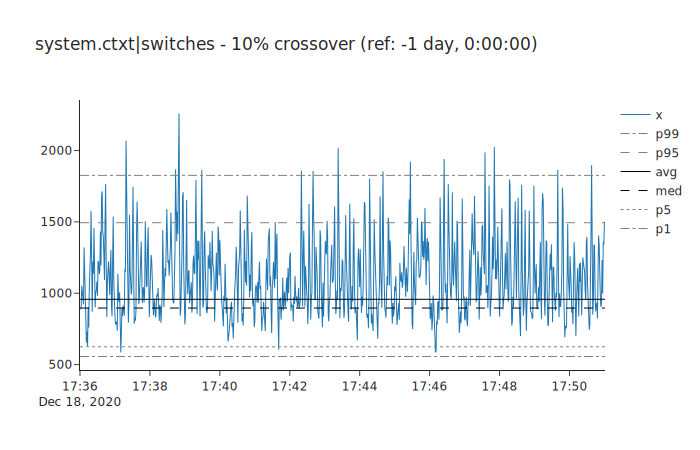

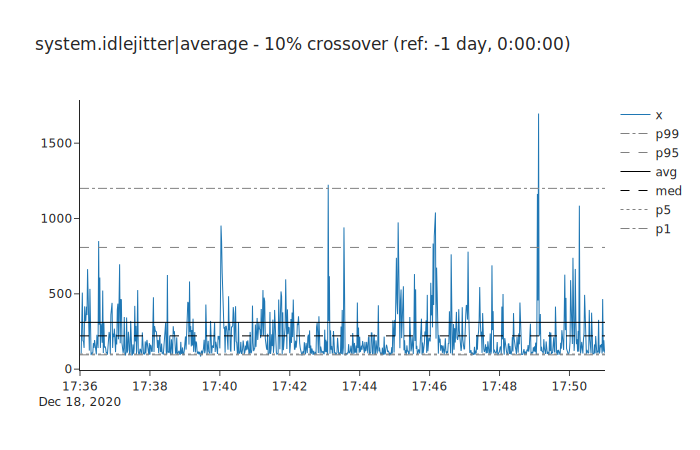

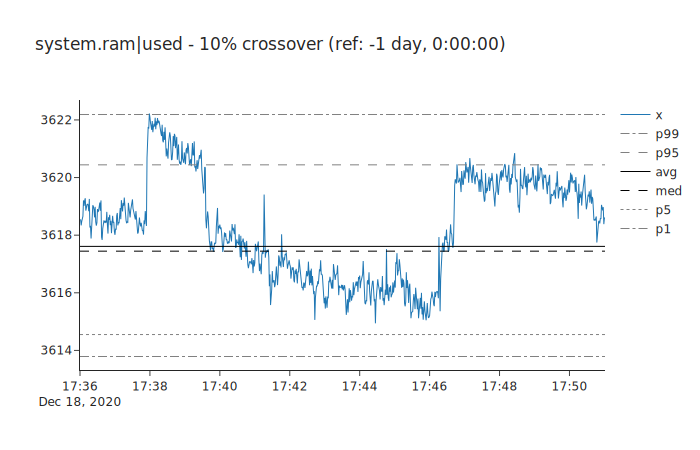

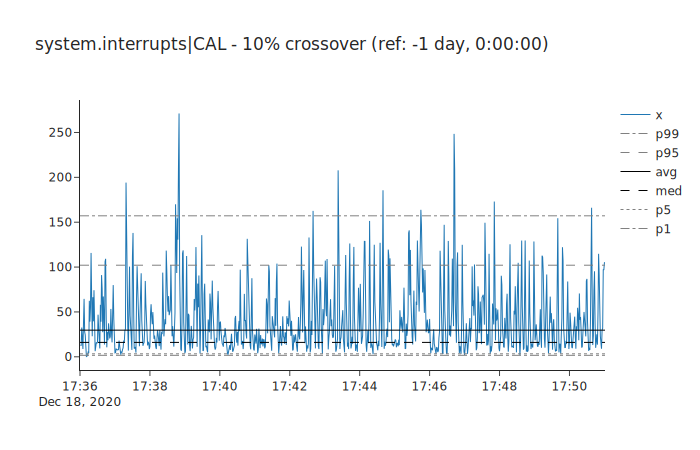

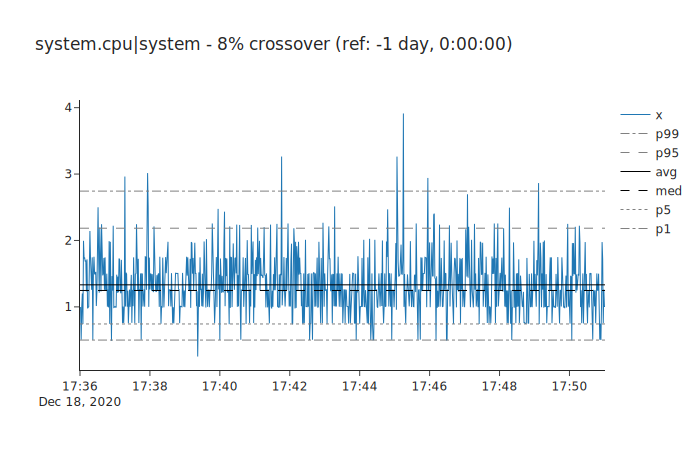

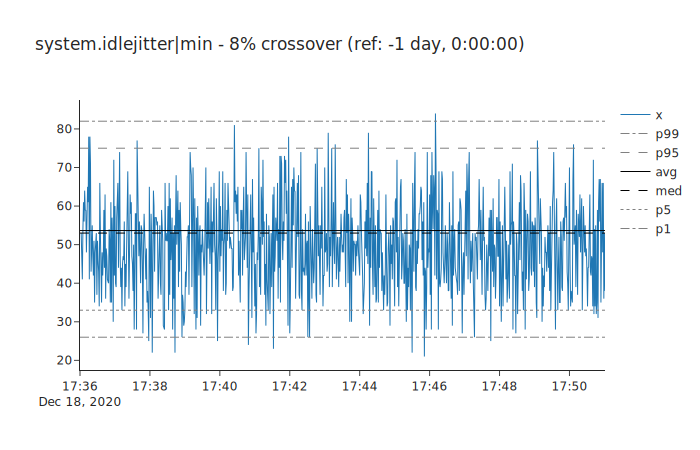

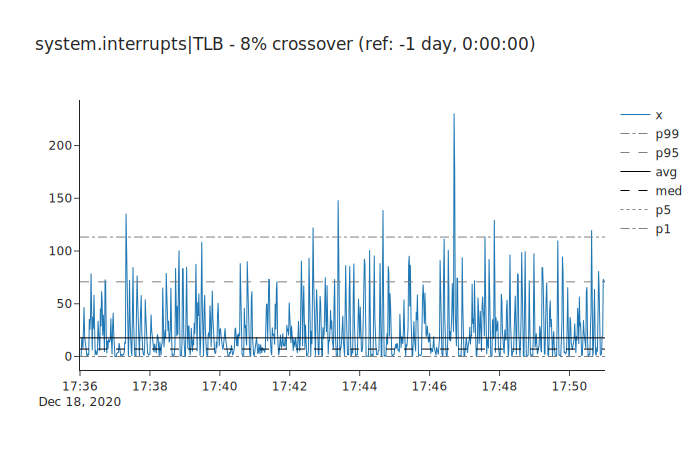

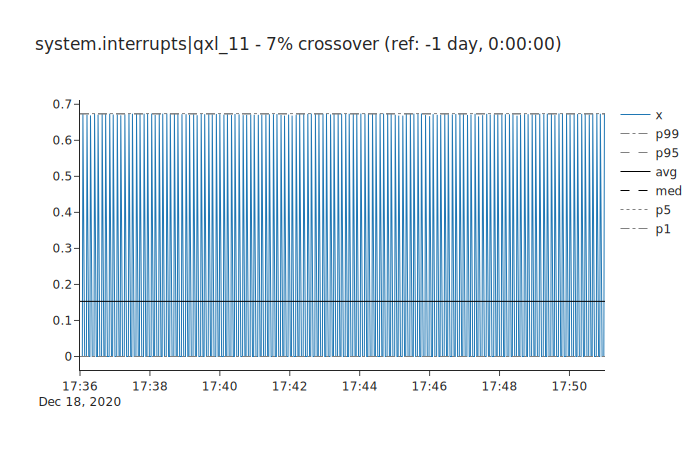

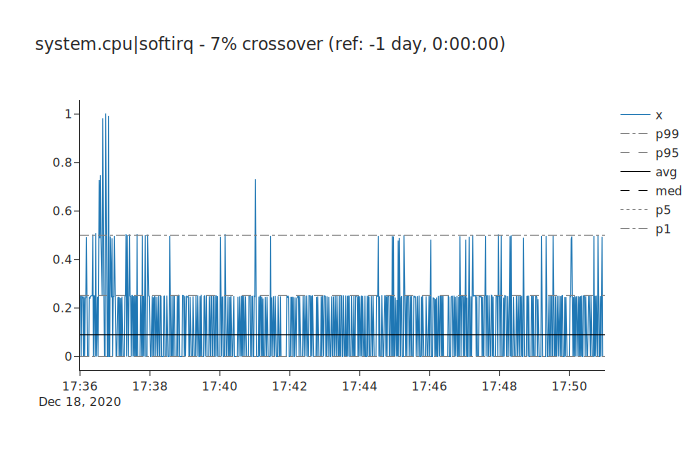

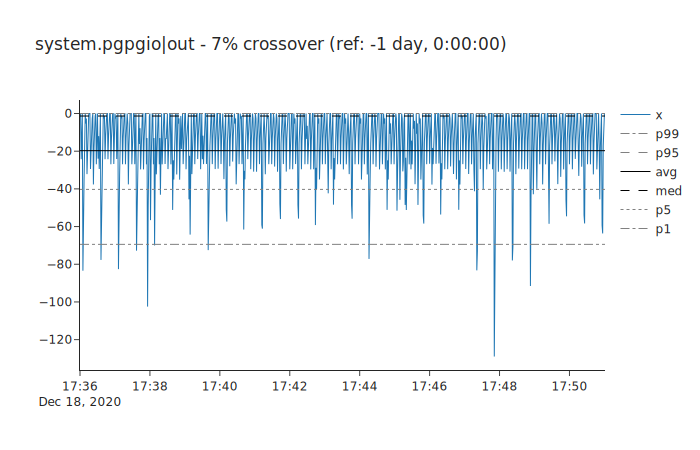

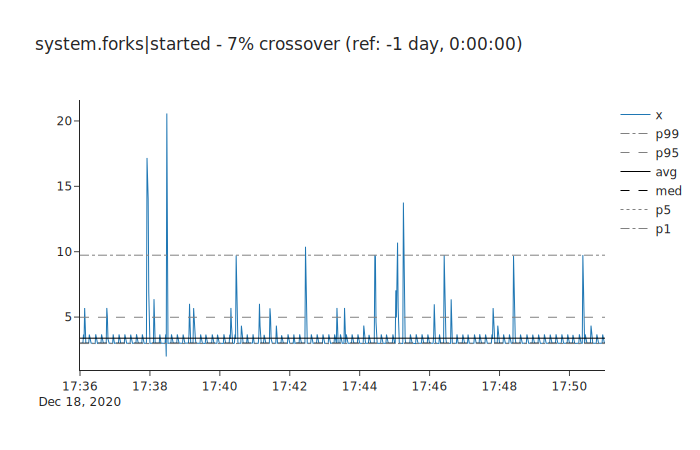

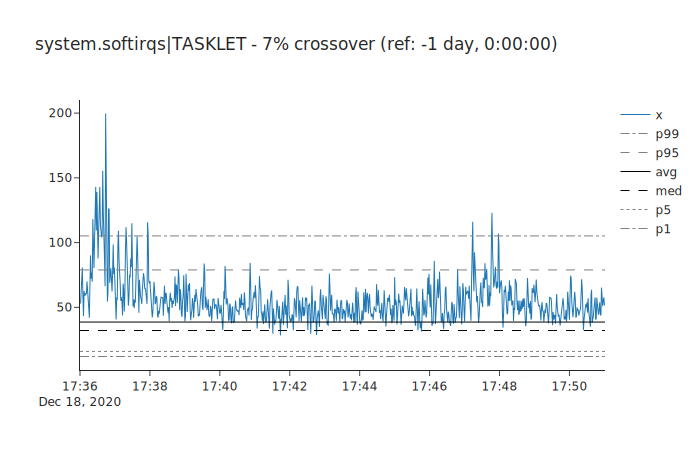

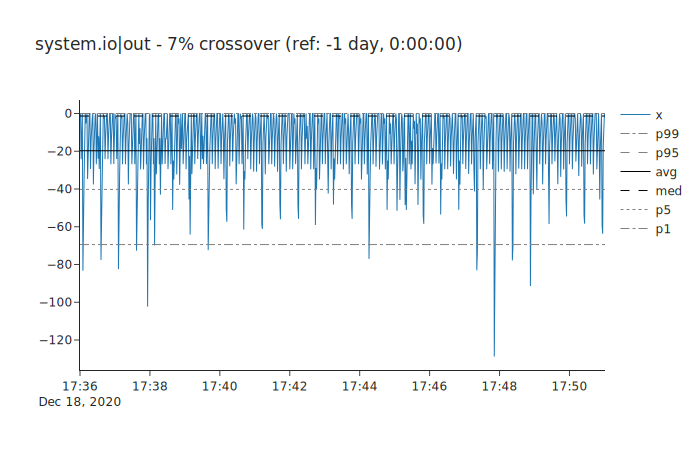

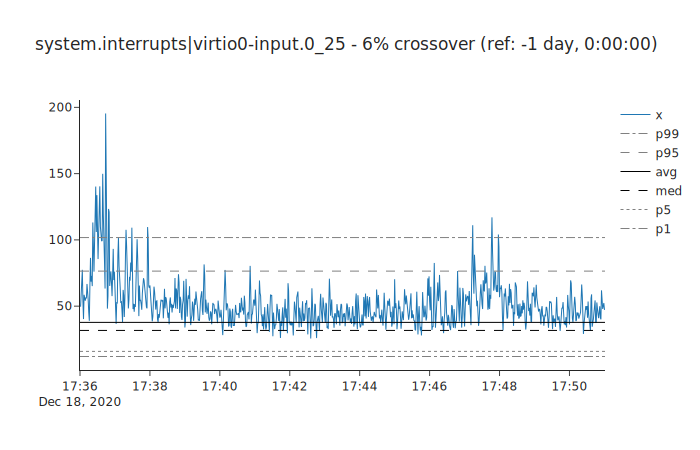

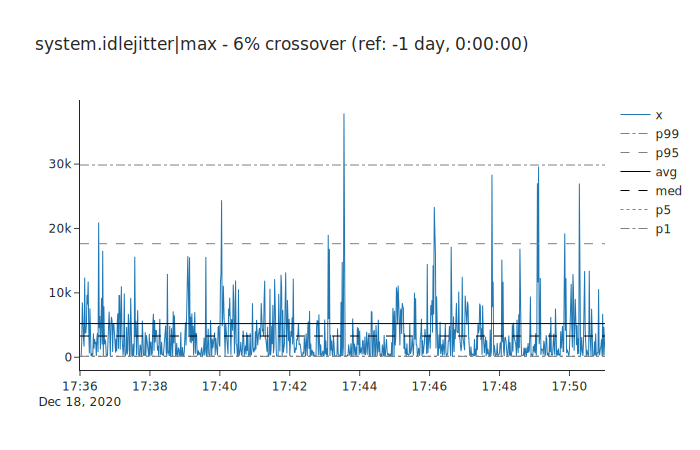

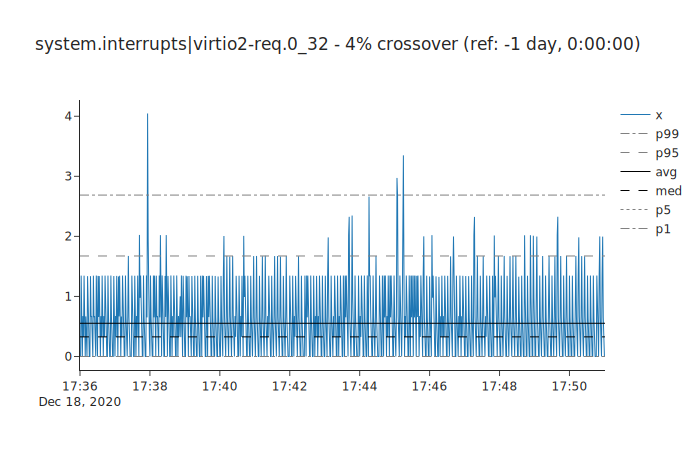

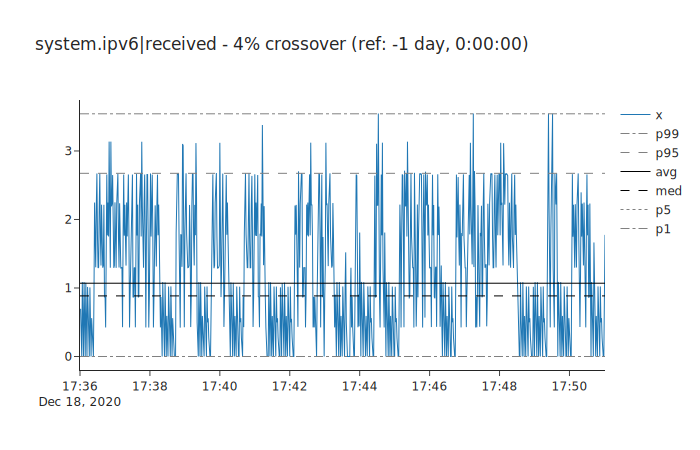

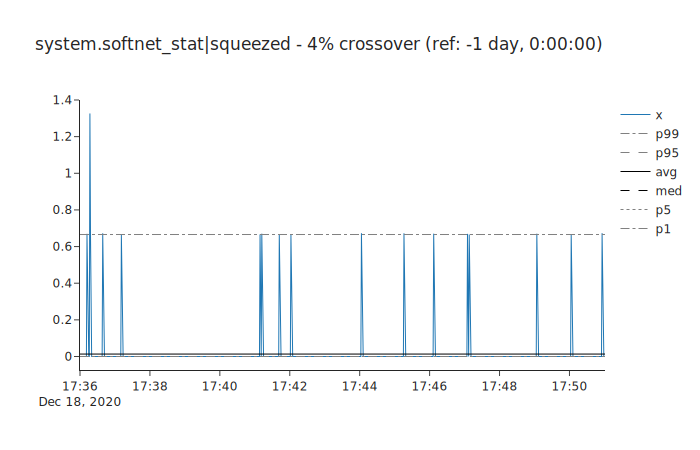

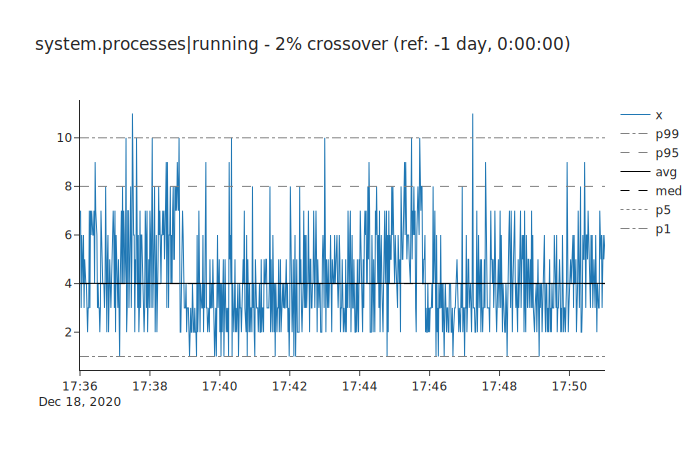

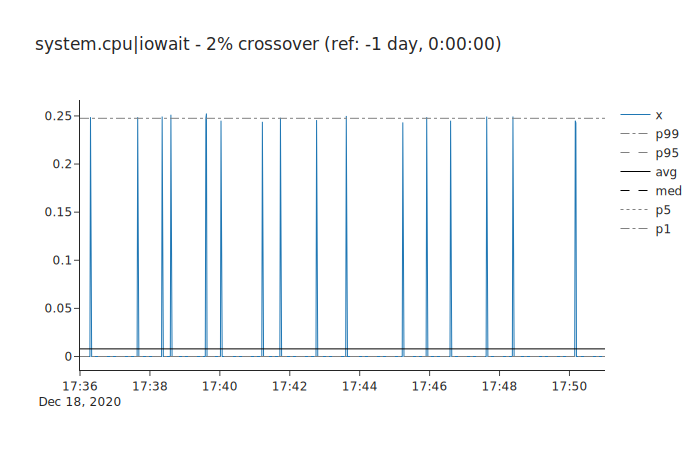

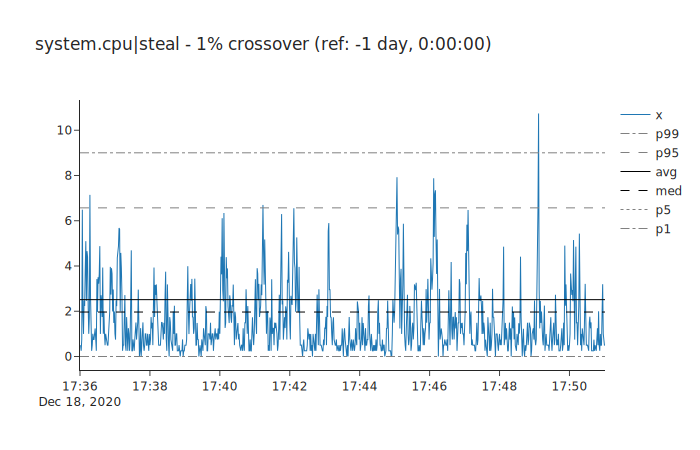

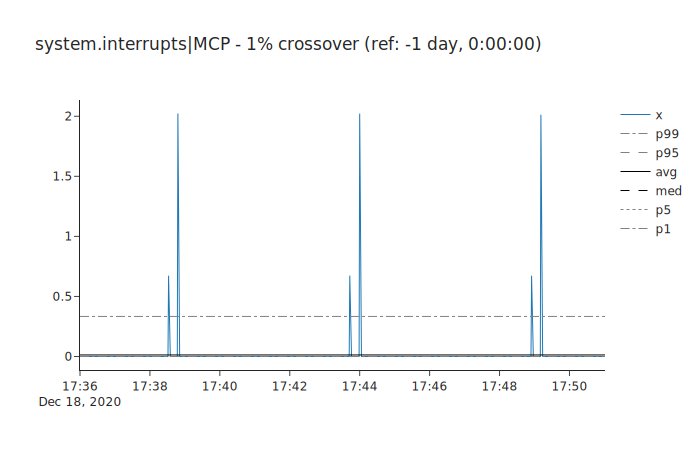

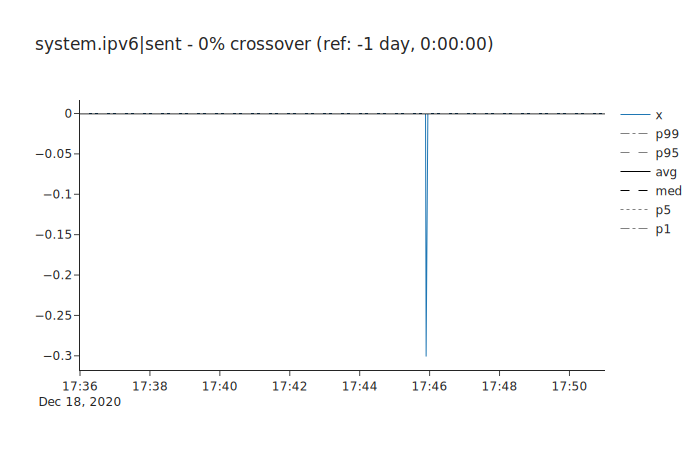

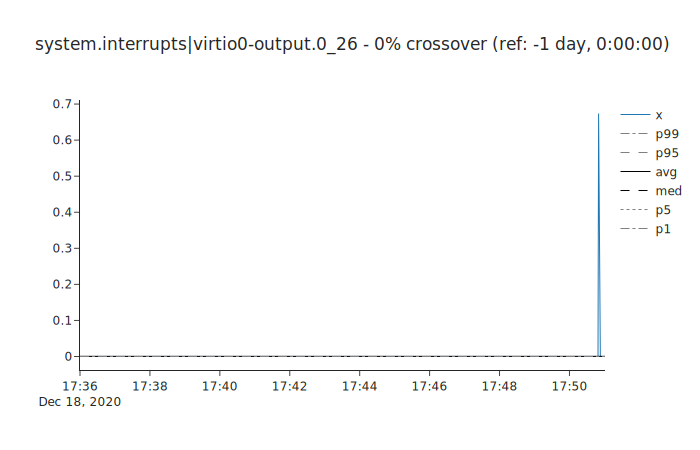

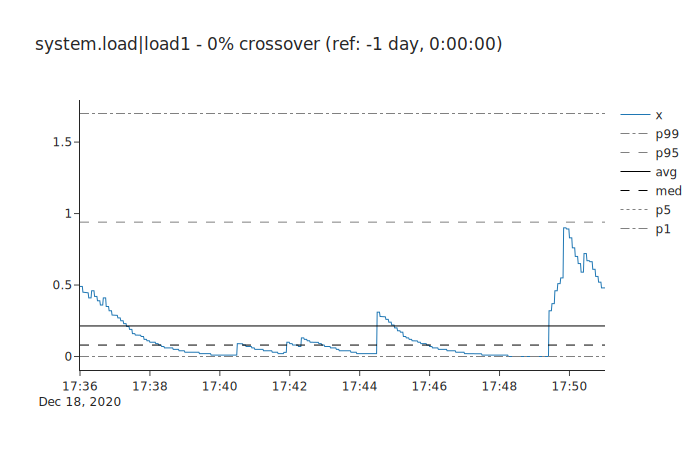

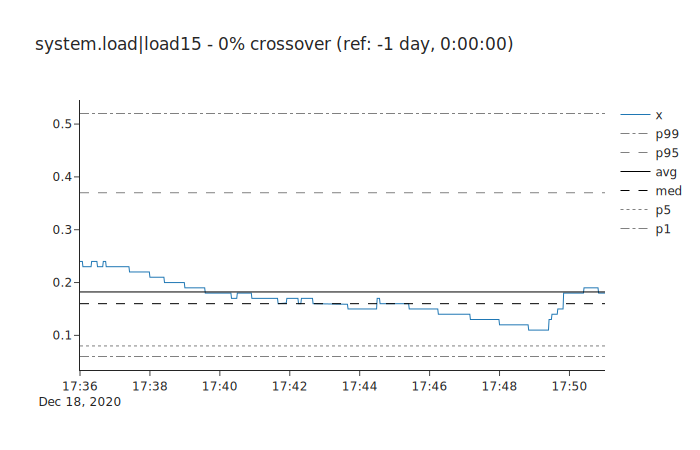

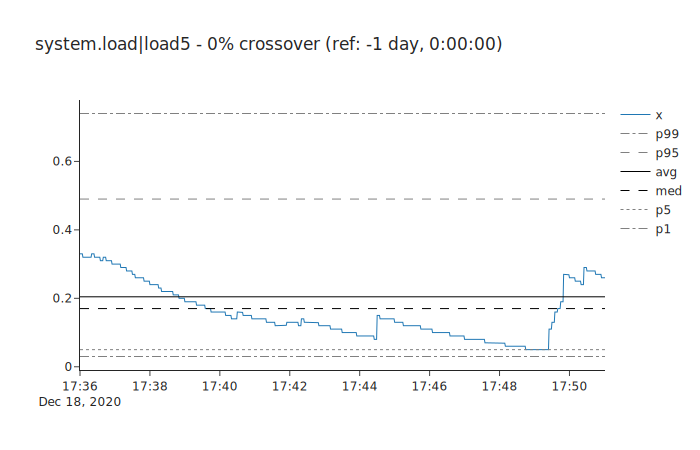

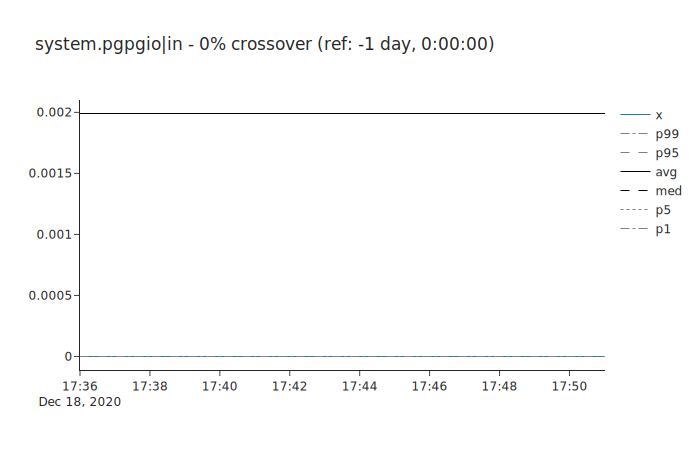

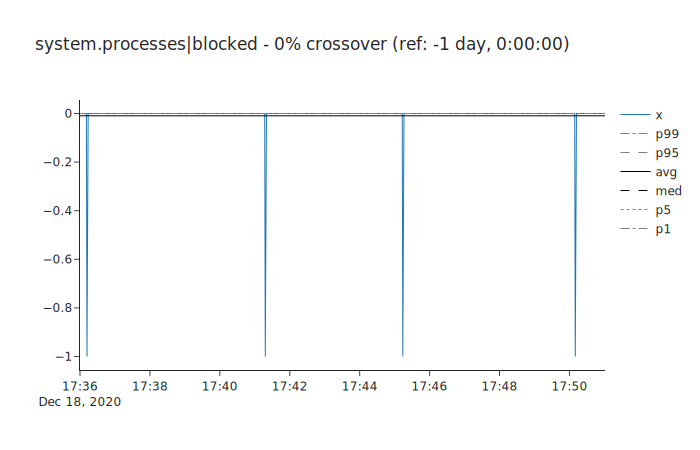

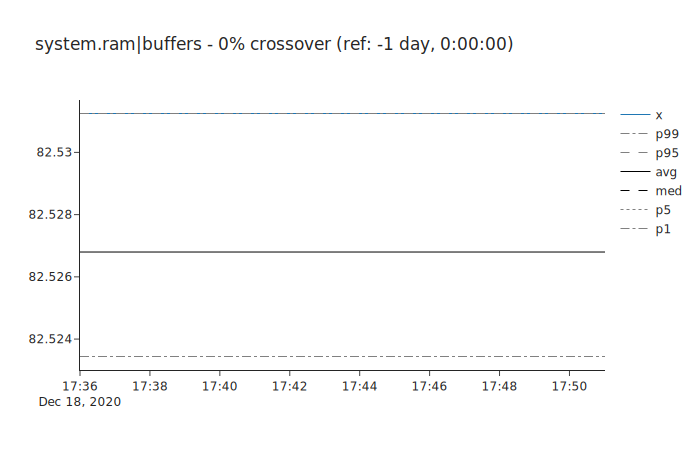

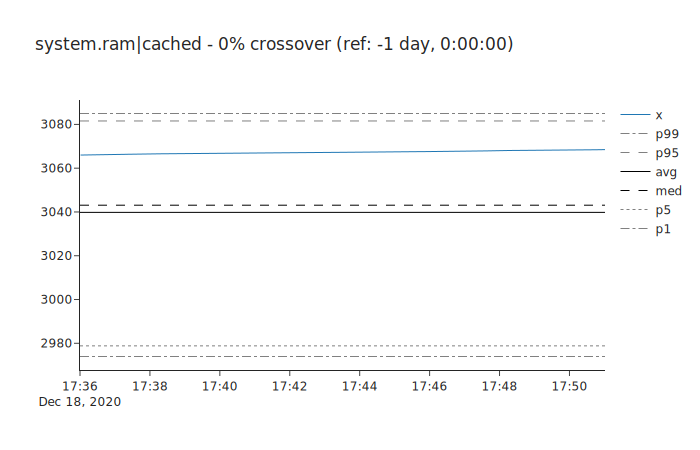

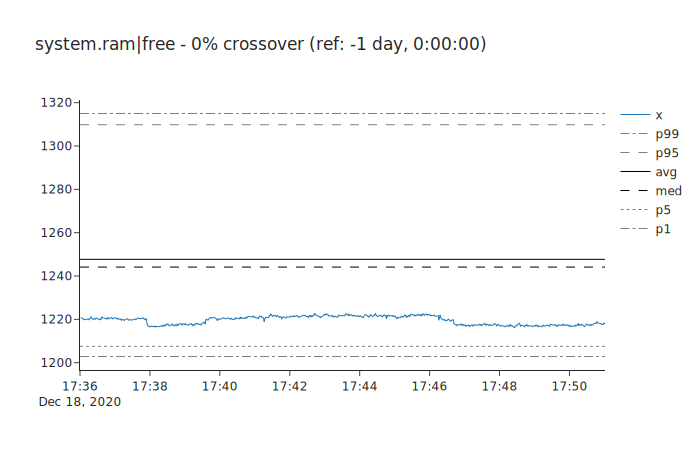

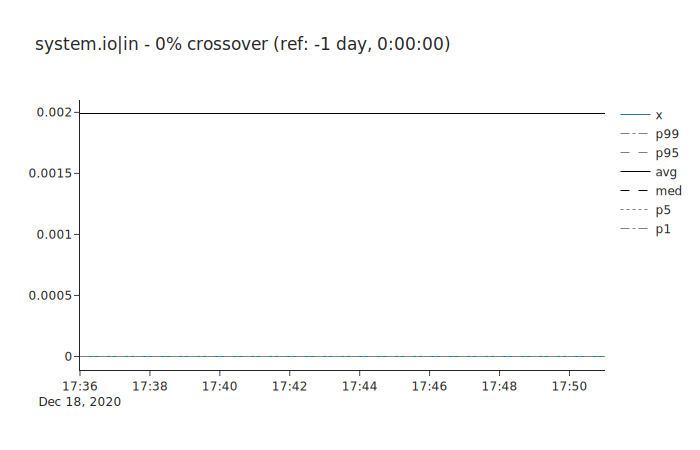

In [8]:
# plot each metric
for col in df_percentile_crossovers.sort_values('metric_rank').index:

    if col in df_ref.columns:

        fig = go.Figure()

        # get data
        n_rows = len(df[col])
        raw_data = df[col]
        p99_data = [df_ref_p99.loc[col] for t in range(n_rows)]
        p95_data = [df_ref_p95.loc[col] for t in range(n_rows)]
        mean_data = [df_ref_mean.loc[col] for t in range(n_rows)]
        median_data = [df_ref_median.loc[col] for t in range(n_rows)]
        p5_data = [df_ref_p5.loc[col] for t in range(n_rows)]
        p1_data = [df_ref_p1.loc[col] for t in range(n_rows)]
        crossover_rate = int(round(100*df_percentile_crossovers.loc[col]['crossover_rate'], 0))
        
        # skip data that is not interesting
        if df_ref_mean.loc[col] == 0 and df_ref_median.loc[col] == 0 and raw_data.mean() == 0:
            continue
        # x
        fig.add_trace(
            go.Scatter(
                x=df.index, y=raw_data, mode='lines', name='x',
                line = dict(width=1)
            )
        )
        # p99
        fig.add_trace(
            go.Scatter(
                x=df.index, y=p99_data, mode='lines', name=f'p99', 
                line = dict(color='grey', width=1, dash='dashdot')
            )
        )
        # p95
        fig.add_trace(
            go.Scatter(
                x=df.index, y=p95_data, mode='lines', name=f'p95', 
                line = dict(color='grey', width=1, dash='dash')
            )
        )
        # mean
        fig.add_trace(
            go.Scatter(
                x=df.index, y=mean_data, mode='lines', name=f'avg', 
                line = dict(color='black', width=1)
            )
        )
        # median
        fig.add_trace(
            go.Scatter(
                x=df.index, y=median_data, mode='lines', name=f'med', 
                line = dict(color='black', width=1, dash='dash')
            )
        )
        # p5
        fig.add_trace(
            go.Scatter(
                x=df.index, y=p5_data, mode='lines', name=f'p5', 
                line = dict(color='grey', width=1, dash='dot')
            )
        )
        # p1
        fig.add_trace(
            go.Scatter(
                x=df.index, y=p1_data, mode='lines', name=f'p1', 
                line = dict(color='grey', width=1, dash='dashdot')
            )
        )
        fig.update_layout(
            template='simple_white', 
            title=f'{col} - {crossover_rate}% crossover (ref: -{ref_timedelta})'
        )
        #fig.show() # for interactive plots
        fig.show('svg')